### DESCRIPTION

Identify the level of income qualification needed for the families in Latin America.

Problem Statement Scenario: Many social programs have a hard time ensuring that the right people are given enough aid. It’s tricky when a program focuses on the poorest segment of the population. This segment of the population can’t provide the necessary income and expense records to prove that they qualify.

In Latin America, a popular method called Proxy Means Test (PMT) uses an algorithm to verify income qualification. With PMT, agencies use a model that considers a family’s observable household attributes like the material of their walls and ceiling or the assets found in their homes to classify them and predict their level of need.

While this is an improvement, accuracy remains a problem as the region’s population grows and poverty declines.

The Inter-American Development Bank (IDB)believes that new methods beyond traditional econometrics, based on a dataset of Costa Rican household characteristics, might help improve PMT’s performance. Following actions should be performed:

* Identify the output variable.
* Understand the type of data.
* Check if there are any biases in your dataset.
* Check whether all members of the house have the same poverty level.
* Check if there is a house without a family head.
* Set poverty level of the members and the head of the house within a family.
* Count how many null values are existing in columns.
* Remove null value rows of the target variable.
* Predict the accuracy using random forest classifier.
* Check the accuracy using random forest with cross validation.

In [75]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib.inline

UsageError: Line magic function `%matplotlib.inline` not found.


In [ ]:
# Load datasets
iq_train = pd.read_csv('train.csv')
iq_test = pd.read_csv('test.csv')

In [ ]:
iq_train.head()

In [ ]:
iq_test.head()

In [ ]:
iq_train.shape

In [ ]:
iq_test.shape

In [ ]:
iq_train.info()

In [ ]:
iq_train.describe()

## 1. Identify the Output Variable

In [ ]:
for i in iq_train.columns:
    if i not in iq_test.columns:
        print("Our Target variable is {}".format(i))

In [ ]:
Y = iq_train['Target']

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(Y)
plt.xlabel('Income Qualification Level')
plt.title('Distribution of Income Qualification')
plt.show()

## 2. Understanding the type of data

In [ ]:
type(iq_train)

In [ ]:
iq_train.info()

In [ ]:
print(iq_train.dtypes.value_counts())

#### We have mixed data types. Specified as below:

* float64 : 8 variables
* int64 : 130 vriables
* object :5 variables

In [ ]:
#lets explore each different types of datasets
for i in iq_train.columns:
    a=iq_train[i].dtype
    if a == 'object':
        print(i)

Id
idhogar
dependency
edjefe
edjefa
Below is Data dictionary for above object variables

* ID = Unique ID
* idhogar, Household level identifier
* dependency, Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
* edjefe, years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
* edjefa, years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

## 3. Check if there are any biases in your dataset.

In [ ]:
iq_train['Target'].value_counts()

In [ ]:
iq_train['Target'].hist()
plt.xlabel('Income Qualification Level')
plt.title('Distribution of Income Qualification')
plt.show()

### Comment:-   The distribution of the target variable above shows that the data is biased towards the 4th class as it has more number of observations than others.

## 4. Check whether all members of the house have the same poverty level.

In [ ]:
# assuming idhogar is unique id for household

non_p_level = sum(iq_train.groupby('idhogar')['Target'].nunique()!=1)

print('Houses with non same poverty level of all the members : ',non_p_level)

In [ ]:
mem_p_level = iq_train.groupby('idhogar')['r4t3'].unique().sum()

print('Houses with same poverty level of all the members : ',mem_p_level)

**Comment:-**  We can say that there are 85 households where all members of the house do not have same poverty level

## 5. Check if there is a house without a family head.

In [ ]:
House_without_Family_head = sum(iq_train.groupby('idhogar')['parentesco1'].sum()==0)

print("Hence we can say that there are", House_without_Family_head, "houses without a family head")

**Commnets:-** Hence we can say that there are 15 houses without a family head

## 6. Set poverty level of the members and the head of the house within a family.

In [ ]:
house_pov = iq_train.groupby ('idhogar').agg ({'Target' : 'nunique'}).Target
for house in house_pov [house_pov > 1].index :
    pov_level = iq_train.loc [(iq_train.idhogar == house) | (iq_train.parentesco1 == 1), 'Target'].values [0]
    iq_train.loc [iq_train.idhogar == house, 'Target'] = pov_level
house_pov = iq_train.groupby ('idhogar').agg ({'Target' : 'nunique'}).Target
print ('\nNumber of household at different poverty levels =', (house_pov > 1).sum ())

## 7. Count how many null values are existing in columns

In [ ]:
# To check for count of missing values in the columns
 
iq_train.isna().sum()[iq_train.isna().any()]

1. We can see that we have huge no. of missing values in the columns, v2a1, v18q1, rez_esc. Hence, we can drop these columns.
2. We can also see missing values in meaneduc and SQBmeaned, having 5 missing values each. We can see the summary statistics of these columns to decide whether to replace with mean or median values

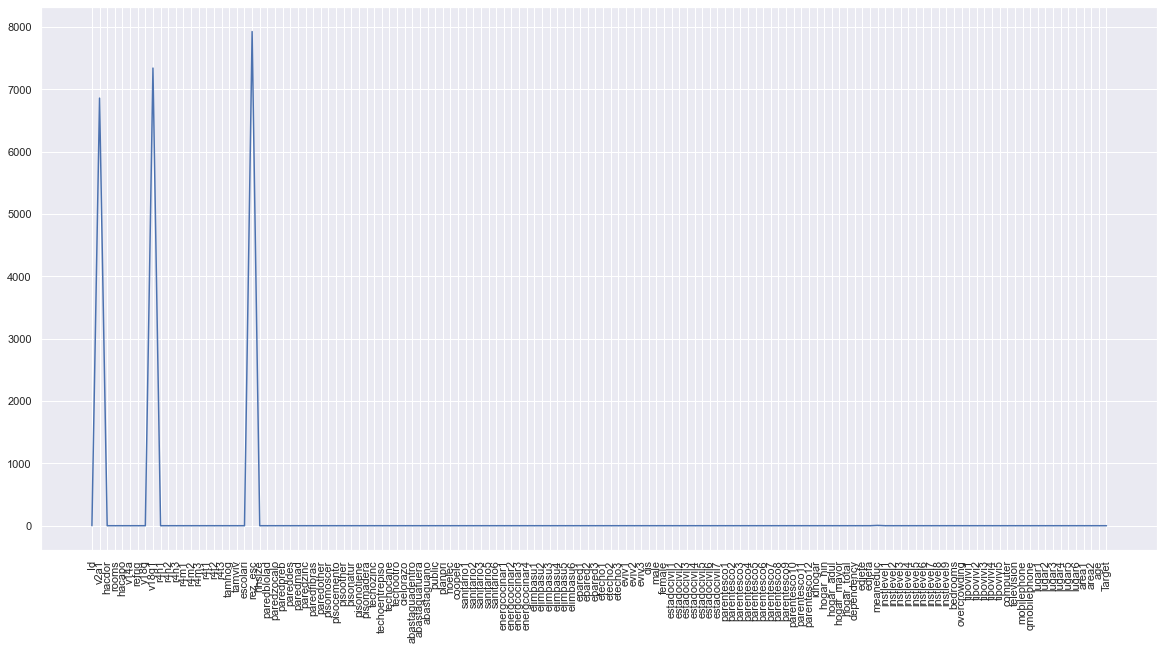

In [76]:
plt.figure(figsize=(20,10))
plt.plot(iq_train.isnull().sum())
plt.xticks(rotation='vertical')
plt.show()

In [77]:
# Treating null values for v18q1 column
# v18q1 in nan can also mean that household owns 0 number of tablet. For this we can verify the v18q column value in which v18q1 is null


iq_test[iq_test['v18q1'].isnull()]['v18q'].unique()

array([0], dtype=int64)

From above code we are checking the value of v18q when v18q1 is nan. Since it is 0 we can conclude that when household does not not own tablet(v18q=0), we have null value in v18q1. Hence we can initialize the null value in v18q1 to 0.

In [78]:
iq_train.loc[iq_train['v18q1'].isnull(),'v18q1'] = 0
iq_train['v18q1'].isnull()

iq_test.loc[iq_test['v18q1'].isnull(),'v18q1'] = 0
iq_test['v18q1'].isnull()

0        False
1        False
2        False
3        False
4        False
         ...  
23851    False
23852    False
23853    False
23854    False
23855    False
Name: v18q1, Length: 23856, dtype: bool

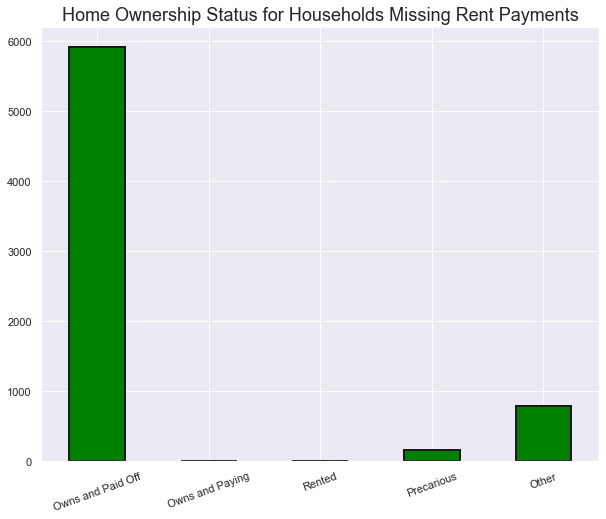

In [79]:
# Treating null values for v2a1 column
# Since monthly rent payment depends on the factor that whenther house is owned or rented. For the house owned rent payment can be 0.
# Hence we need to check the tipovivi1, tipovivi2, tipovivi3, tipovivi4, tipovivi5 values
# Variables indicating home ownership
own_variables = [x for x in iq_train if x.startswith('tipo')]

# Plot of the home ownership variables for home missing rent payments
iq_train.loc[iq_train['v2a1'].isnull(), own_variables].sum().plot.bar(figsize = (10, 8),
                                                                        color = 'green',
                                                              edgecolor = 'k', linewidth = 2);
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 20)
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18);

Since the house rent payment is null mostly for house owned, we will sit house rent payment 0 where it is missing.

In [80]:
iq_train.loc[iq_train['v2a1'].isnull(),'v2a1'] = 0
iq_train['v2a1'].isnull()

iq_test.loc[iq_test['v2a1'].isnull(),'v2a1'] = 0
iq_test['v2a1'].isnull()

0        False
1        False
2        False
3        False
4        False
         ...  
23851    False
23852    False
23853    False
23854    False
23855    False
Name: v2a1, Length: 23856, dtype: bool

In [81]:
# Treating null values for column rez_esc
# rez_esc or years behind in school can be null for household having no children. So we will look the ages of household members for which rez_esc is null

iq_train[iq_train['rez_esc'].isnull()]['age'].describe()

count    7928.000000
mean       38.833249
std        20.989486
min         0.000000
25%        24.000000
50%        38.000000
75%        54.000000
max        97.000000
Name: age, dtype: float64

In [82]:
iq_train[(iq_train['rez_esc'].isnull())]['age'].unique()

array([43, 67, 92, 37, 38, 30, 28, 18, 34, 79, 39, 19, 70, 50, 22, 26, 69,
       66, 41, 20, 40, 44, 62, 33, 35, 56, 52, 36, 24, 76, 94, 45, 48, 42,
       71, 29, 55,  1, 60, 74, 57, 31, 89, 59,  4, 46, 75, 78, 53, 63, 51,
       21, 47, 49, 68, 73, 97, 72,  6,  5, 58, 27,  3,  2, 61, 25,  0, 23,
       54, 32, 65, 77, 81, 88, 64, 87, 82, 95, 80, 85, 83, 84, 90, 86, 91,
       93, 10], dtype=int64)

Since for individuals having age < 7 and > 19 years behind in school is null. We can assume it as 0 because the individuals below 7 years age and above 19 years will not be going to school

In [83]:
iq_train.loc[(iq_train['rez_esc'].isnull()), 'rez_esc'] = 0
iq_test.loc[(iq_test['rez_esc'].isnull()), 'rez_esc'] = 0

In [84]:
# Treating meanedu null values

iq_train.loc[(iq_train['meaneduc'].isnull()), 'meaneduc'] = 0
iq_test.loc[(iq_test['meaneduc'].isnull()), 'meaneduc'] = 0

In [85]:
# We will again check the null values

dict = {}
def checkNull(df):
    for col in df.columns:
        if df[col].isnull().any():
            dict[col] = df[col].isnull().sum()

checkNull(iq_train)
print('Number of null value columns in training dataset ',dict)
checkNull(iq_test)
print('Number of null value columns in testing dataset ',dict)

Number of null value columns in training dataset  {}
Number of null value columns in testing dataset  {}


## 8. Remove null value rows of the target variable.

In [90]:
iq_train['Target'].isnull().any()

False

In [91]:
iq_train[iq_train['Target'].isnull()==False]

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,0.0,0,...,1,0,0,0,0,0,1,0,43,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,1,0,0,0,0,0,1,0,67,4
2,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,0,...,1,0,0,0,0,0,1,0,92,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,1,0,0,0,0,0,1,0,17,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,1,0,0,0,0,0,1,0,37,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9552,ID_d45ae367d,80000.0,0,6,0,1,1,0,0.0,0,...,0,0,0,0,0,1,0,1,46,2
9553,ID_c94744e07,80000.0,0,6,0,1,1,0,0.0,0,...,0,0,0,0,0,1,0,1,2,2
9554,ID_85fc658f8,80000.0,0,6,0,1,1,0,0.0,0,...,0,0,0,0,0,1,0,1,50,2
9555,ID_ced540c61,80000.0,0,6,0,1,1,0,0.0,0,...,0,0,0,0,0,1,0,1,26,2


## 9. Predict the accuracy using random forest classifier

In [102]:
# We will drop column in a pair having correlation > 0.95

# Create correlation matrix
corr_matrix = iq_train.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]
to_drop

C:\Users\Kirtesh Pawar\AppData\Local\Temp\ipykernel_20484\2472567833.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


['tamhog', 'hhsize', 'coopele', 'female', 'hogar_total', 'area2']

In [103]:
iq_train.shape

(9557, 134)

In [104]:
iq_test.shape

(23856, 133)

In [105]:
# label encoding object types

from sklearn.preprocessing import LabelEncoder

In [106]:
lbl = LabelEncoder()

In [107]:
iq_train.select_dtypes('object').head()

,Id,idhogar
0,ID_279628684,21eb7fcc1
1,ID_f29eb3ddd,0e5d7a658
2,ID_68de51c94,2c7317ea8
3,ID_d671db89c,2b58d945f
4,ID_d56d6f5f5,2b58d945f


In [108]:
iq_train['dependency'] = lbl.fit_transform(iq_train['dependency'])
iq_train['edjefe'] = lbl.fit_transform(iq_train['edjefe'])
iq_train['edjefa'] = lbl.fit_transform(iq_train['edjefa'])

iq_test['dependency'] = lbl.fit_transform(iq_test['dependency'])
iq_test['edjefe'] = lbl.fit_transform(iq_test['edjefe'])
iq_test['edjefa'] = lbl.fit_transform(iq_test['edjefa'])

In [109]:
iq_train.select_dtypes('float').head()

,v2a1,v18q1,rez_esc,meaneduc,overcrowding
0,190000.0,0.0,0.0,10.0,1.000000
1,135000.0,1.0,0.0,12.0,1.000000
2,0.0,0.0,0.0,11.0,0.500000
3,180000.0,1.0,1.0,11.0,1.333333
4,180000.0,1.0,0.0,11.0,1.333333


In [110]:
# Since the value of monthly payment rent is too large we will try to normalize it by dividing it by it's mean

iq_train['v2a1'] = round(iq_train['v2a1']/iq_train['v2a1'].mean(),2)
iq_test['v2a1'] = round(iq_test['v2a1']/iq_test['v2a1'].mean(),2)

In [111]:
# rounding of overcrowding column to 2 decimal places

iq_train['overcrowding'] = round(iq_train['overcrowding'],2)
iq_test['overcrowding'] = round(iq_test['overcrowding'],2)

In [112]:
from sklearn.ensemble import RandomForestClassifier

In [113]:
model = RandomForestClassifier(n_estimators=100, random_state=10, 
                               n_jobs = -1)

In [114]:
# dropping Id, idhogar and target column to build training dataframe

X = iq_train.drop(['Id','Target','idhogar'], axis=1)

In [115]:
model.fit(X, Y)

RandomForestClassifier(n_jobs=-1, random_state=10)

In [116]:
X_test = iq_test.drop(['Id','idhogar'], axis=1)

In [117]:
# predicting the values for testing dataset

model.predict(X_test)

array([4, 4, 4, ..., 4, 4, 4], dtype=int64)

## 10. Check the accuracy using random forest with cross validation.

In [118]:
from sklearn.model_selection import cross_val_score
all_accuracies = cross_val_score(estimator=model, X=X, y=Y, cv=10)

In [119]:
all_accuracies.mean()

0.6395071085894543

Hence we have predicted the accuracy using 10 fold sampling. Accuracy of the model is 63.9%